## DBSCAN

#### Incidentally, I am going to elaborately explain the algorithm and the code themselves since DBSCAN is a bit complex and the code alone is not straightforward in order to correctly understand the algorithm.

In [1]:
import math
import random
import matplotlib.pyplot as plt

random.seed(42)

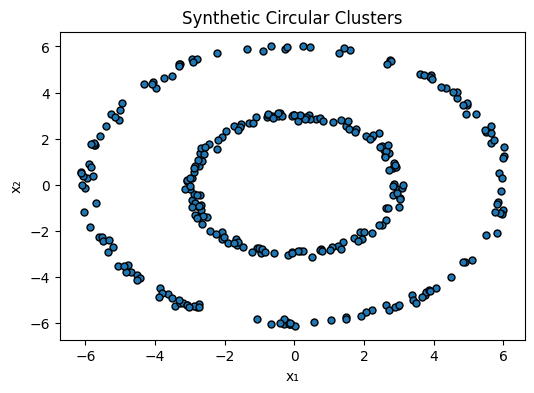

In [3]:
def generate_circles(n_samples=300, noise=0.1):
    points = []

    # There'll be 2 circles
    # First circle
    for _ in range(n_samples // 2):
        angle = random.uniform(0, 2 * math.pi)
        r = 3 + random.gauss(0, noise)
        x = r * math.cos(angle)
        y = r * math.sin(angle)
        points.append((x, y))
    # Second circle
    for _ in range(n_samples // 2):
        angle = random.uniform(0, 2 * math.pi)
        r = 6 + random.gauss(0, noise)
        x = r * math.cos(angle)
        y = r * math.sin(angle)
        points.append((x, y))
    return points

X = generate_circles()

xs, ys = zip(*X)
plt.figure(figsize=(6, 4))
plt.scatter(xs, ys, edgecolors='k', s=25)
plt.title("Synthetic Circular Clusters")
plt.xlabel("x₁"); plt.ylabel("x₂")
plt.show()


In [4]:
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [5]:
def region_query(points, point_idx, eps):
    neighbors = []
    point = points[point_idx]
    for i, other_point in enumerate(points):
        if euclidean_distance(point, other_point) <= eps:
            neighbors.append(i)
    return neighbors

In [6]:
def expand_cluster(points, labels, point_idx, cluster_id, eps, min_pts, visited):
    seeds = region_query(points, point_idx, eps)
    if len(seeds) < min_pts:
        labels[point_idx] = -1
        return False
    else:
        labels[point_idx] = cluster_id
        for seed_idx in seeds:
            if seed_idx != point_idx:
                labels[seed_idx] = cluster_id
        i = 0
        while i < len(seeds):
            current_point = seeds[i]
            if not visited[current_point]:
                visited[current_point] = True
                result = region_query(points, current_point, eps)
                if len(result) >= min_pts:
                    for r in result:
                        if labels[r] == 0:
                            labels[r] = cluster_id
                            seeds.append(r)
            i += 1
        return True

### Now we are at the main part - the declaration of class:

In [7]:
class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts

    def fit(self, points):
        n = len(points)
        self.labels_ = [0] * n
        # Explanation
        # 0  = unclassified
        #-1  = noise
        # 1+ = cluster IDs
        visited = [False] * n
        cluster_id = 0

        for i in range(n):
            if visited[i]:
                continue
            visited[i] = True
            if expand_cluster(points, self.labels_, i, cluster_id + 1, self.eps, self.min_pts, visited):
                cluster_id += 1

        self.n_clusters_ = cluster_id
        return self

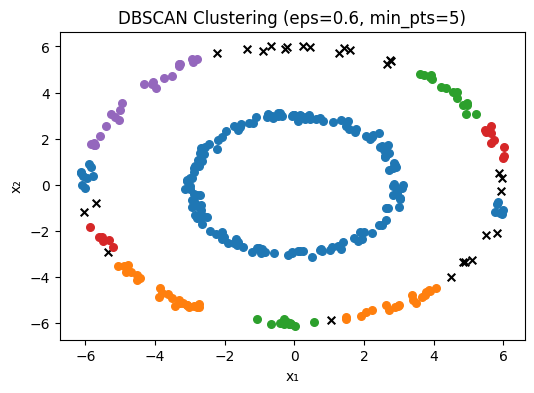

In [8]:
model = DBSCAN(eps=0.6, min_pts=5)
model.fit(X)
labels = model.labels_

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(6, 4))
for i, point in enumerate(X):
    label = labels[i]
    if label == -1:
        plt.scatter(point[0], point[1], color='k', marker='x', s=30, label='Noise' if i == 0 else "")
    else:
        plt.scatter(point[0], point[1], color=colors[(label - 1) % len(colors)], s=30)

plt.title(f'DBSCAN Clustering (eps={model.eps}, min_pts={model.min_pts})')
plt.xlabel('x₁'); plt.ylabel('x₂')
plt.show()

## What We Have Understood from DBSCAN

### What is DBSCAN anyway?
DBSCAN is a clustering algorithm that groups points based on how closely packed they are. Unlike K-Means, it does not require you to choose the number of clusters in advance and can find clusters of arbitrary shape—even noisy, non-circular ones.

### How Does It Work?
DBSCAN depends on two main parameters
They are:
- **ε (epsilon)** - the maximum distance to consider a point a neighbour
- **minPts** - the minimum number of neighbours required to form a dense region

With these two parameters:
- A point is a core point if it has at least `minPts` points (including itself) within `eps` distance.
- A point is a border point if it’s within `eps` of a core point but has fewer than `minPts` neighbours itself.
- A point is noise if it’s not a core point and not within `eps` of any core point.


## How the DBSCAN Class Works to Find Clusters

Let's go through this question by answering each part step by step, shall we?

### What Are the Main Parameters?
- **eps:** This is how close points need to be to each other to be considered neighbours.
- **min_pts:** The minimum number of points needed nearby to form a cluster.


### What Happens Inside the `fit` Method?

First, the algorithm counts how many points there are in the dataset. Then, it creates a list to store labels for each point.

These labels can be:
* `0`, which means the point hasn’t been classified yet,
* `-1`, which means the point is considered noise and doesn’t belong to any cluster,
* or a **positive number** (`1`, `2`, `3`, and so on), which represent cluster IDs.

The algorithm also keeps track of which points have already been visited. At the start, the number of clusters found is zero.

**Next**, the algorithm goes through each point one by one.
If a point has already been visited:
* it skips it.
Otherwise:
* it marks the point as visited and tries to expand a cluster from this point using a helper function called `expand_cluster`.

This function checks the point’s neighbours within the distance defined by eps. If there are enough neighbours (at least `min_pts`), it either forms a new cluster or adds to an existing one.

Points that can be reached from this one are added to the cluster. If the cluster was successfully created or expanded, the count of clusters is increased by one.

After all points have been checked, the list of labels shows which cluster each point belongs to or if it is noise.

The total number of clusters found is also stored.




### What Does This Mean for Predictions?

- DBSCAN doesn’t “predict” new points like some other algorithms.
- It labels the points you give it, grouping them into clusters or noise.
- You can then use these labels to understand the data or visualise it.
